In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

### Data Preprocessing

Vamos a limpiar el dataset ver que tantos valores nulos y NaN tiene y veremos que variables debemos estandarizar o aplicar algun tipo de encoding, para saber cuales son las más relacionadas, cuales eliminamos y cuales se quedan. En principio segun mi criterio personal, podemos eliminar algunas como customer ID, Churn category, Churn Reason, entre otras...  ya que tienen relacion directa con nuestra variable objetivo "Customer Status" **y algunas no aportan nada al modelo a simple vista.**

In [6]:
df['Contract']

0             One Year
1       Month-to-Month
2       Month-to-Month
3       Month-to-Month
4       Month-to-Month
             ...      
7038          One Year
7039    Month-to-Month
7040    Month-to-Month
7041          Two Year
7042          Two Year
Name: Contract, Length: 7043, dtype: object

In [7]:
columns_del = ['Customer ID',
               'Churn Reason','Zip Code','Latitude',
               'Longitude','Avg Monthly Long Distance Charges',
               'Avg Monthly GB Download','Total Refunds',
               'Total Long Distance Charges']
df.drop(columns_del, axis=1, inplace=True)

In [8]:
df.columns.values

array(['Gender', 'Age', 'Married', 'Number of Dependents', 'City',
       'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Internet Type', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data',
       'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charge', 'Total Charges', 'Total Extra Data Charges',
       'Total Revenue', 'Customer Status', 'Churn Category'], dtype=object)

In [9]:
### Veremos que valores Nulos hay o NaN

nan_values = df.isna().sum()
print(nan_values,'\n')

Gender                         0
Age                            0
Married                        0
Number of Dependents           0
City                           0
Number of Referrals            0
Tenure in Months               0
Offer                       3877
Phone Service                  0
Multiple Lines               682
Internet Service               0
Internet Type               1526
Online Security             1526
Online Backup               1526
Device Protection Plan      1526
Premium Tech Support        1526
Streaming TV                1526
Streaming Movies            1526
Streaming Music             1526
Unlimited Data              1526
Contract                       0
Paperless Billing              0
Payment Method                 0
Monthly Charge                 0
Total Charges                  0
Total Extra Data Charges       0
Total Revenue                  0
Customer Status                0
Churn Category              5174
dtype: int64 



### Vamos a trabajar esos valores nulos, a ver de donde vienen y como podemos reemplazarlos.

Sin embargo segun un analisis anterior sabemos que los valores nulos de Offer vienen de personas que no les ha sido aplicada ninguna oferta.

In [10]:
# df['Offer']

In [11]:
# rellenando los NaN
df['Offer'].fillna(value='No Offer', inplace=True)

In [12]:
df['Churn Category'].fillna(value='No Churn', inplace=True)

In [13]:
df['Churn Category'].value_counts()

Churn Category
No Churn           5174
Competitor          841
Dissatisfaction     321
Attitude            314
Price               211
Other               182
Name: count, dtype: int64

In [14]:
df['Internet Type'].unique()

array(['Cable', 'Fiber Optic', 'DSL', nan], dtype=object)

In [15]:
# Voy a eliminar city, porque creo qeu no aporta nada.
columns_del = ['City']
df.drop(columns_del, axis=1, inplace=True)

In [16]:
# Juntemos Joined y stayed en una sola para mejorar nuestra variable objetivo
df['Customer Status'] = df['Customer Status'].replace({'Joined': 'Stayed'})

In [17]:
df['Customer Status']

0        Stayed
1        Stayed
2       Churned
3       Churned
4       Churned
         ...   
7038     Stayed
7039    Churned
7040     Stayed
7041     Stayed
7042     Stayed
Name: Customer Status, Length: 7043, dtype: object

In [18]:
nan_values = df.isna().sum()
print(nan_values,'\n')

Gender                         0
Age                            0
Married                        0
Number of Dependents           0
Number of Referrals            0
Tenure in Months               0
Offer                          0
Phone Service                  0
Multiple Lines               682
Internet Service               0
Internet Type               1526
Online Security             1526
Online Backup               1526
Device Protection Plan      1526
Premium Tech Support        1526
Streaming TV                1526
Streaming Movies            1526
Streaming Music             1526
Unlimited Data              1526
Contract                       0
Paperless Billing              0
Payment Method                 0
Monthly Charge                 0
Total Charges                  0
Total Extra Data Charges       0
Total Revenue                  0
Customer Status                0
Churn Category                 0
dtype: int64 



In [19]:
num_valores_unicos = df.nunique()

# Mostrar el resultado
num_valores_unicos

Gender                         2
Age                           62
Married                        2
Number of Dependents          10
Number of Referrals           12
Tenure in Months              72
Offer                          6
Phone Service                  2
Multiple Lines                 2
Internet Service               2
Internet Type                  3
Online Security                2
Online Backup                  2
Device Protection Plan         2
Premium Tech Support           2
Streaming TV                   2
Streaming Movies               2
Streaming Music                2
Unlimited Data                 2
Contract                       3
Paperless Billing              2
Payment Method                 3
Monthly Charge              1591
Total Charges               6540
Total Extra Data Charges      16
Total Revenue               6975
Customer Status                2
Churn Category                 6
dtype: int64

In [20]:
df['Unlimited Data']

0       Yes
1        No
2       Yes
3       Yes
4       Yes
       ... 
7038    Yes
7039    Yes
7040    Yes
7041    Yes
7042    Yes
Name: Unlimited Data, Length: 7043, dtype: object

In [21]:
#convertir variables categoricas en variables numéricas
#churned 1
#stayed 0
label_encoder = LabelEncoder()
df['Customer Status'] = label_encoder.fit_transform(df['Customer Status'])

In [22]:
# Otras columnas binarias para LabelEncoder.
columnas = ['Streaming TV', 'Gender','Paperless Billing',
           'Unlimited Data','Streaming Music','Streaming Movies','Streaming TV',
           'Premium Tech Support','Device Protection Plan','Online Backup',
           'Online Security','Internet Service','Multiple Lines','Phone Service',
            'Married']

for columna in columnas:
    df[columna] = label_encoder.fit_transform(df[columna])

In [23]:
df['Customer Status'].value_counts()

Customer Status
1    5174
0    1869
Name: count, dtype: int64

In [24]:
nan_values = df.isna().sum()
print(nan_values,'\n')

Gender                         0
Age                            0
Married                        0
Number of Dependents           0
Number of Referrals            0
Tenure in Months               0
Offer                          0
Phone Service                  0
Multiple Lines                 0
Internet Service               0
Internet Type               1526
Online Security                0
Online Backup                  0
Device Protection Plan         0
Premium Tech Support           0
Streaming TV                   0
Streaming Movies               0
Streaming Music                0
Unlimited Data                 0
Contract                       0
Paperless Billing              0
Payment Method                 0
Monthly Charge                 0
Total Charges                  0
Total Extra Data Charges       0
Total Revenue                  0
Customer Status                0
Churn Category                 0
dtype: int64 



In [25]:
df['Internet Type'].fillna(value='No Internet', inplace=True)

In [26]:
#Encoding otras caracteristicas con mas de dos clases. con One Hot Encoding de Pandas

df = pd.get_dummies(df)

In [27]:
num_valores_unicos = df.nunique()

# Mostrar el resultado
num_valores_unicos

Gender                               2
Age                                 62
Married                              2
Number of Dependents                10
Number of Referrals                 12
Tenure in Months                    72
Phone Service                        2
Multiple Lines                       3
Internet Service                     2
Online Security                      3
Online Backup                        3
Device Protection Plan               3
Premium Tech Support                 3
Streaming TV                         3
Streaming Movies                     3
Streaming Music                      3
Unlimited Data                       3
Paperless Billing                    2
Monthly Charge                    1591
Total Charges                     6540
Total Extra Data Charges            16
Total Revenue                     6975
Customer Status                      2
Offer_No Offer                       2
Offer_Offer A                        2
Offer_Offer B            

In [28]:
# Dataset Auxiliar.
df2 = pd.read_csv('dataset.csv')

**Vamos a estandarizar datos numericos que tienen mucha divergencia, como total Charges, Total, Revenue, Monthly Charge, y tenure in months** Vamos a aplicar MinMaxScaler

In [29]:
df['Total Charges'].value_counts()

Total Charges
20.20      11
19.75       9
19.90       8
20.05       8
19.65       8
           ..
829.55      1
625.65      1
462.80      1
251.25      1
3707.60     1
Name: count, Length: 6540, dtype: int64

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas a escalar
columns_to_scale = ['Tenure in Months', 'Total Charges', 'Monthly Charge', 'Total Revenue', 'Age']

# Crear una instancia del MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar las columnas seleccionadas
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Mostrar el DataFrame resultante
df

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check,Churn Category_Attitude,Churn Category_Competitor,Churn Category_Dissatisfaction,Churn Category_No Churn,Churn Category_Other,Churn Category_Price
0,0,0.295082,1,0,2,0.112676,1,0,1,0,...,False,False,True,False,False,False,False,True,False,False
1,1,0.442623,0,0,0,0.112676,1,1,1,0,...,False,False,True,False,False,False,False,True,False,False
2,1,0.508197,0,0,0,0.042254,1,0,1,0,...,False,True,False,False,False,True,False,False,False,False
3,1,0.967213,1,0,1,0.169014,1,0,1,0,...,False,True,False,False,False,False,True,False,False,False
4,0,0.918033,1,0,3,0.028169,1,0,1,0,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0.016393,0,0,0,0.169014,1,0,1,1,...,False,False,True,False,False,False,False,True,False,False
7039,1,0.344262,1,0,1,0.295775,1,1,1,0,...,False,True,False,False,False,False,True,False,False,False
7040,1,0.049180,0,0,0,0.014085,1,0,1,0,...,False,False,True,False,False,False,False,True,False,False
7041,1,0.032787,1,0,5,0.929577,1,0,1,1,...,True,False,True,False,False,False,False,True,False,False


In [253]:
df

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Phone Service,Multiple Lines,Internet Service,Internet Type,...,Offer_Offer D,Offer_Offer E,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check,Customer Status_Churned,Customer Status_Stayed
0,0,0.295082,1,0,2,0.112676,1,0,1,0,...,False,False,False,True,False,False,True,False,False,True
1,1,0.442623,0,0,0,0.112676,1,1,1,0,...,False,False,True,False,False,False,True,False,False,True
2,1,0.508197,0,0,0,0.042254,1,0,1,2,...,False,True,True,False,False,True,False,False,True,False
3,1,0.967213,1,0,1,0.169014,1,0,1,2,...,True,False,True,False,False,True,False,False,True,False
4,0,0.918033,1,0,3,0.028169,1,0,1,2,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0.016393,0,0,0,0.169014,1,0,1,1,...,True,False,False,True,False,False,True,False,False,True
7039,1,0.344262,1,0,1,0.295775,1,1,1,2,...,True,False,True,False,False,True,False,False,True,False
7040,1,0.049180,0,0,0,0.014085,1,0,1,1,...,False,True,True,False,False,False,True,False,False,True
7041,1,0.032787,1,0,5,0.929577,1,0,1,0,...,False,False,False,False,True,False,True,False,False,True


### Perfecto, al parecer ya tenemos un dataset mas o menos limpio y procesado. pero ahora empieza lo bueno.

Vamos a mirar las correlaciones que tienen las demas caracteristicas con nuestra variable objetivo, para ver cuales se quedan cuales se van y cuales son ams importantes.

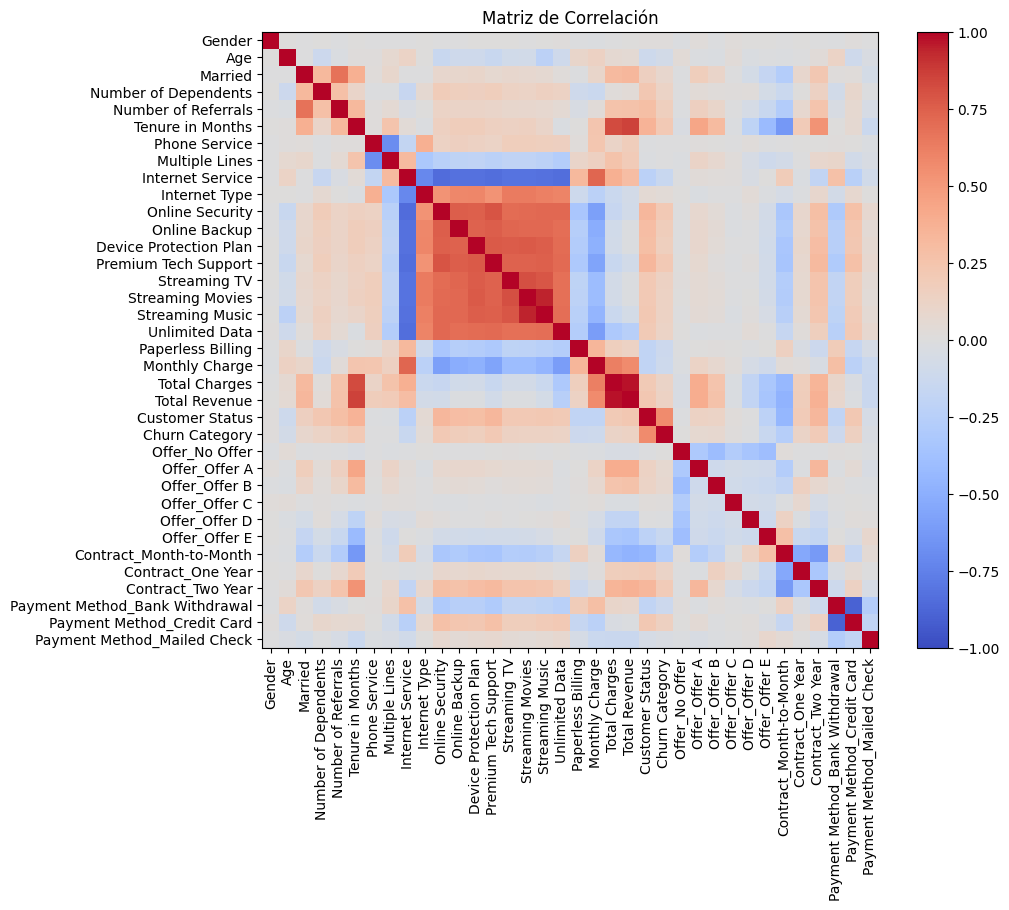

In [283]:
# Matriz de correlaciones entre caracteristicas
import pandas as pd
import matplotlib.pyplot as plt

# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Configura la figura y los ejes del gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Crea el gráfico de matriz de correlación
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Agrega una barra de color
plt.colorbar(im)

# Configura las etiquetas de los ejes
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

# Agrega un título
ax.set_title('Matriz de Correlación')

# Muestra el gráfico
plt.show()


### Sin sorpresas, hay muchas caracteristicas correlacionadas. que podemos eliminar.

### La correlación mide la relación lineal entre dos variables. Las características con alta correlación son más linealmente dependientes y tienen casi el mismo efecto sobre la variable dependiente. 

### Entonces, cuando dos características tienen una correlación alta, podemos descartar una de ellas. En nuestro caso, podemos eliminar características altamente correlacionadas como <span style="color:red">Multiple Lines, Online Security, OnlineBackup, DeviceProtection, Premium Tech Support, Streaming TV y Streaming Movies y quedarnos solo con una de ellas.<span>

In [44]:
df.columns.values

array(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming TV', 'Streaming Movies', 'Streaming Music',
       'Unlimited Data', 'Paperless Billing', 'Monthly Charge',
       'Total Charges', 'Total Extra Data Charges', 'Total Revenue',
       'Customer Status', 'Offer_No Offer', 'Offer_Offer A',
       'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E',
       'Internet Type_Cable', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Internet Type_No Internet',
       'Contract_Month-to-Month', 'Contract_One Year',
       'Contract_Two Year', 'Payment Method_Bank Withdrawal',
       'Payment Method_Credit Card', 'Payment Method_Mailed Check',
       'Churn Category_Attitude', 'Churn Category_Competitor',
       'Churn Category_Dissatisfaction', 

In [45]:
columns_del = ['Churn Category_Price','Churn Category_Other','Churn Category_No Churn',
              'Churn Category_Dissatisfaction','Churn Category_Competitor',
              'Churn Category_Attitude']
df.drop(columns_del, axis=1, inplace=True)

In [47]:
X = df.drop('Customer Status', axis=1)
y = df['Customer Status']

<Axes: >

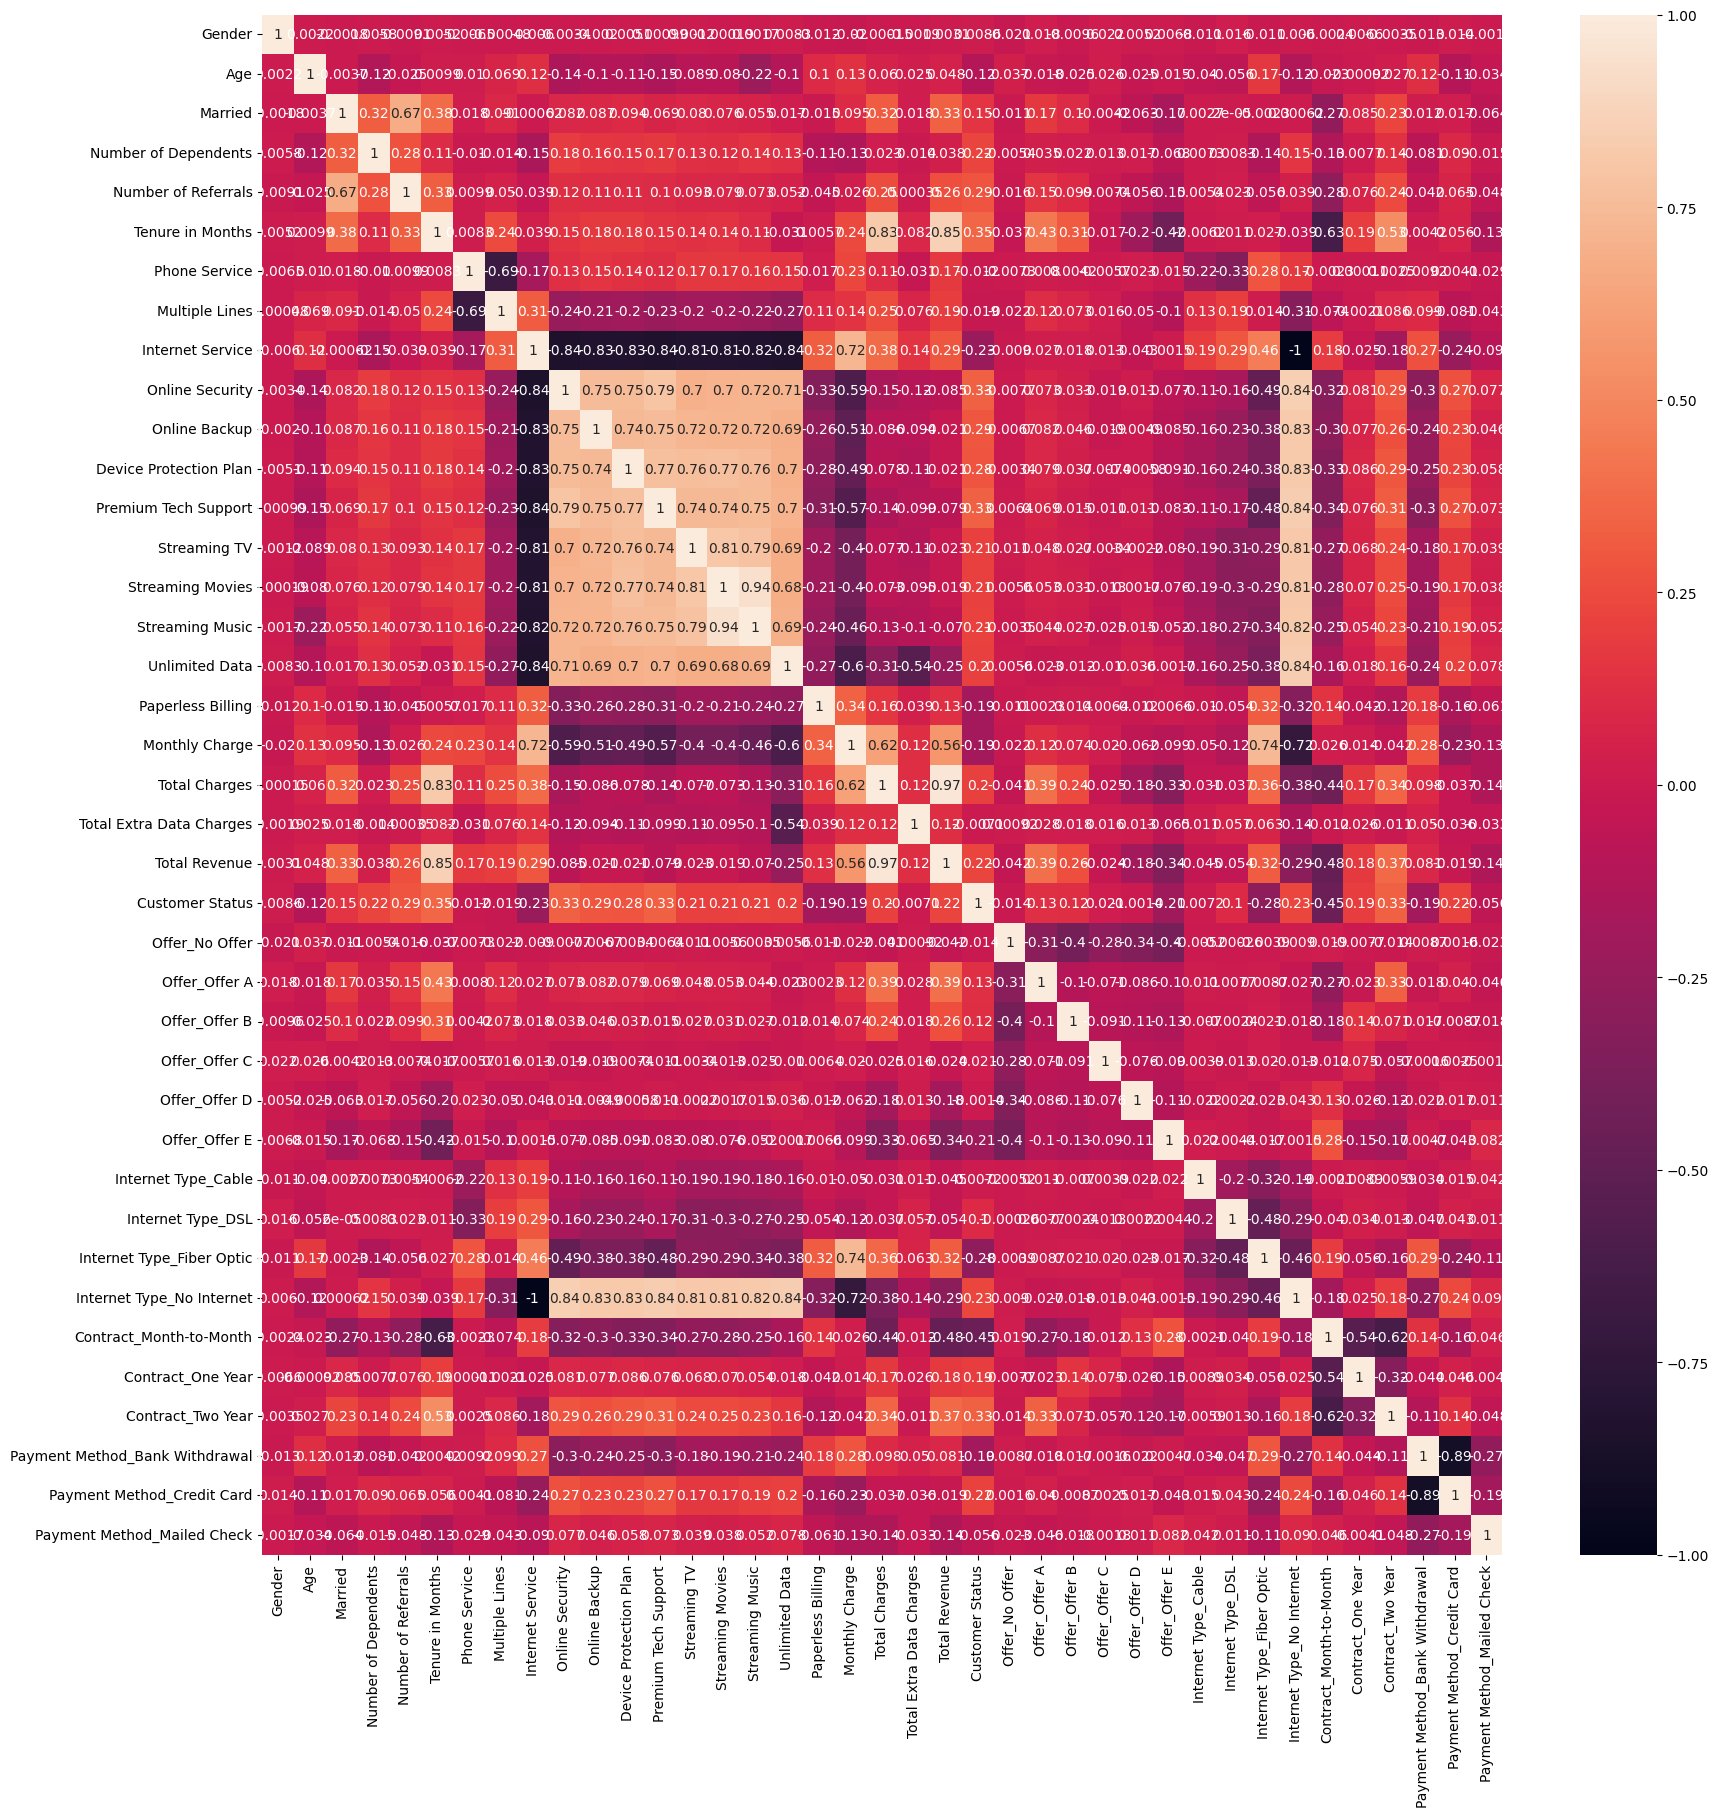

In [46]:
plt.figure(figsize=(20,20))
m_corr = df.corr()
m_corr_top = m_corr.index
sns.heatmap(df[m_corr_top].corr(), annot=True)

### Análisis de componentes principales

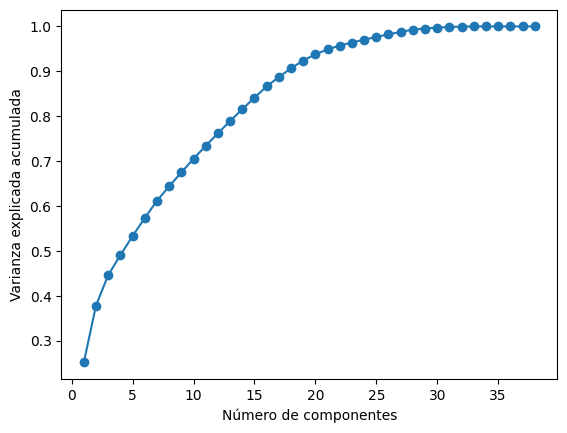

                     Gender           Age       Married  Number of Dependents   
Componente 1   1.954159e-03 -5.399487e-02  2.226755e-02          6.585893e-02  \
Componente 2  -8.555698e-04  2.129878e-02  2.334483e-01          7.434234e-02   
Componente 3   1.445527e-02 -8.934755e-02  8.122933e-02          1.114805e-01   
Componente 4  -2.178219e-02  9.413881e-02  8.293432e-02          2.762593e-02   
Componente 5   3.610064e-02 -6.433581e-02 -3.924674e-03          1.642391e-03   
Componente 6  -1.262198e-02 -9.620832e-02  5.084648e-01          4.455196e-01   
Componente 7  -3.308510e-03 -4.885377e-02  1.850069e-01          1.429830e-01   
Componente 8   6.580787e-02 -4.580855e-02 -5.234812e-02          9.131122e-03   
Componente 9   6.342108e-04  2.437075e-02  4.038162e-02          1.053075e-01   
Componente 10 -8.736875e-02 -2.390558e-01 -4.977175e-02          2.726643e-02   
Componente 11  2.271034e-01  2.928484e-01  1.583345e-02         -2.959535e-02   
Componente 12 -8.377680e-03 

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()  # Crea una instancia de PCA sin especificar el número de componentes
X_pca = pca.fit_transform(X_scaled)  # Aplica PCA a los datos escalados

# Varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Graficar la varianza explicada acumulada
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.show()

# Visualizar los componentes principales
component_names = ['Componente {}'.format(i+1) for i in range(len(explained_variance_ratio))]
component_df = pd.DataFrame(pca.components_, columns=X.columns, index=component_names)
print(component_df)

In [50]:
n_components = 21  # selecciona el número de componentes principales
pca_final = PCA(n_components=n_components)
X_final = pca_final.fit_transform(X_scaled)

In [51]:
# Obtener los nombres de las características originales
feature_names = X.columns

# Obtener los componentes principales
components = pca_final.components_

# Recorrer los componentes principales
for i, component in enumerate(components):
    # Obtener los índices de los elementos más importantes en el componente
    top_indices = component.argsort()[-5:][::-1]
    
    # Obtener los nombres de las características correspondientes a los índices
    top_features = [feature_names[index] for index in top_indices]
    
    print("Componente", i+1)
    print("Características más importantes:", top_features)
    print()


Componente 1
Características más importantes: ['Internet Type_No Internet', 'Premium Tech Support', 'Online Security', 'Streaming Music', 'Device Protection Plan']

Componente 2
Características más importantes: ['Tenure in Months', 'Total Revenue', 'Total Charges', 'Contract_Two Year', 'Married']

Componente 3
Características más importantes: ['Internet Type_DSL', 'Multiple Lines', 'Payment Method_Credit Card', 'Internet Type_Cable', 'Number of Dependents']

Componente 4
Características más importantes: ['Payment Method_Bank Withdrawal', 'Multiple Lines', 'Offer_No Offer', 'Age', 'Married']

Componente 5
Características más importantes: ['Offer_Offer E', 'Offer_Offer B', 'Offer_Offer D', 'Offer_Offer A', 'Offer_Offer C']

Componente 6
Características más importantes: ['Number of Referrals', 'Married', 'Number of Dependents', 'Contract_Month-to-Month', 'Phone Service']

Componente 7
Características más importantes: ['Contract_One Year', 'Offer_Offer B', 'Married', 'Number of Referrals',

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


In [53]:
df.columns.values

array(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming TV', 'Streaming Movies', 'Streaming Music',
       'Unlimited Data', 'Paperless Billing', 'Monthly Charge',
       'Total Charges', 'Total Extra Data Charges', 'Total Revenue',
       'Customer Status', 'Offer_No Offer', 'Offer_Offer A',
       'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E',
       'Internet Type_Cable', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Internet Type_No Internet',
       'Contract_Month-to-Month', 'Contract_One Year',
       'Contract_Two Year', 'Payment Method_Bank Withdrawal',
       'Payment Method_Credit Card', 'Payment Method_Mailed Check'],
      dtype=object)

In [286]:
columns_del = ['Streaming Music','Streaming TV','Streaming Movies',
               'Online Backup','Device Protection Plan', 'Streaming Movies',
              'Total Charges']
df.drop(columns_del, axis=1, inplace=True)

In [162]:
# Funcion Para eliminar columnas

def eliminar_columna(dataframe, columna):
    if columna in dataframe.columns:
        # Eliminar la columna
        dataframe.drop(columna, axis=1, inplace=True)
        print("Columna '{}' eliminada correctamente.".format(columna))
    else:
        print("La columna '{}' no existe en el DataFrame.".format(columna))


In [317]:
eliminar_columna(df, 'Churn Category')

Columna 'Churn Category' eliminada correctamente.


In [319]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state=47)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [55]:
# CHURN = 0
# NO CHURN = 1

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predecimos con regresion logistica.

lr = LogisticRegression()

lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)

print("Logistic Regression:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-score:", lr_f1)
print("\nClassification Report:\n", lr_report)
print('----------------------------------------------------------------')
# Arboles de Decision

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred)

print("Decision Tree:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)
print("\nClassification Report:\n", dt_report)
print('----------------------------------------------------------------')
# Random Forest

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)

print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print("\nClassification Report:\n", rf_report)

Logistic Regression:
Accuracy: 0.8225691980127751
Precision: 0.873574144486692
Recall: 0.887065637065637
F1-score: 0.8802681992337166

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.64      0.66       373
           1       0.87      0.89      0.88      1036

    accuracy                           0.82      1409
   macro avg       0.77      0.77      0.77      1409
weighted avg       0.82      0.82      0.82      1409

----------------------------------------------------------------
Decision Tree:
Accuracy: 0.7665010645848119
Precision: 0.8469087340529932
Recall: 0.833011583011583
F1-score: 0.8399026763990267

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.58      0.57       373
           1       0.85      0.83      0.84      1036

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.70      1409
weighted avg       0.77

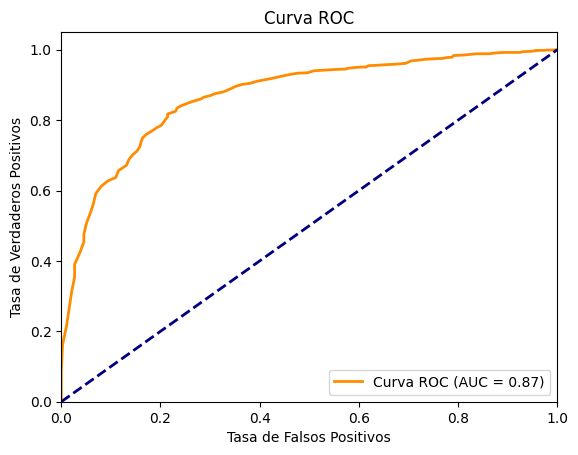

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular las probabilidades de predicción para la clase positiva podemos cambiar segun el modelo (rf,dt,lr)

probas = rf.predict_proba(X_test)
probas = probas[:, 1]  # Obtener las probabilidades de la clase positiva

# Calcular la tasa de verdaderos positivos, la tasa de falsos positivos y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, probas)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Trazar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [323]:
# Aunque no es necesario, siempre me gusta Crear una matriz DMatrix para mejorar el rendimiento de xgboost.
# Los datos de entrenamiento ya los tenemos creados.

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir los parámetros del modelo
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Entrenar el modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Paso 6: Realizar predicciones con el conjunto de prueba
y_pred = model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Paso 7: Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8392958546280522
Precision: 0.8792198049512379
Recall: 0.9057187017001546
F1-score: 0.8922725542443853


AUC: 0.8963714922107967


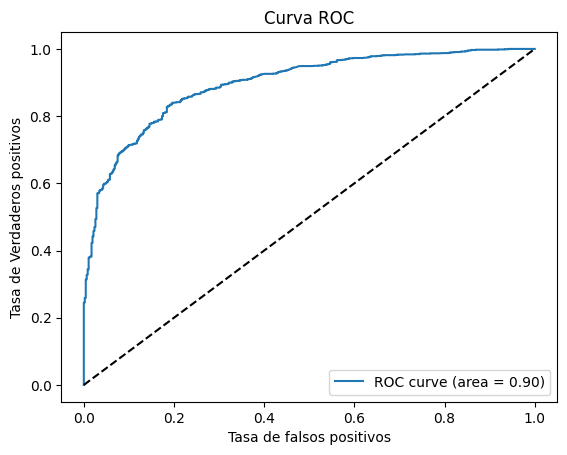

In [324]:
from sklearn.metrics import roc_curve, auc
y_prob = model.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia para una clasificación aleatoria
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
